Running experiment with 10 seeds...
  Seed 1 completed.
  Seed 2 completed.
  Seed 3 completed.
  Seed 4 completed.
  Seed 5 completed.
  Seed 6 completed.
  Seed 7 completed.
  Seed 8 completed.
  Seed 9 completed.
  Seed 10 completed.


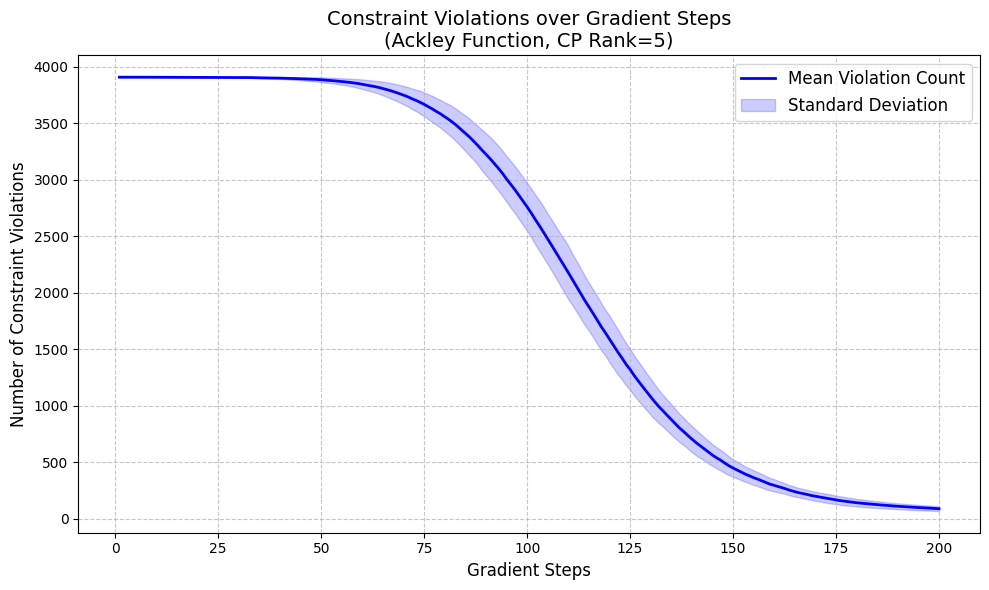

In [1]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import logging

# ==============================================================================
# 1. クラス定義 (提供コードの再利用 + 一部修正)
# ==============================================================================

class AckleyTF:
    """
    提供された AckleyTF クラス (変更なし)
    ただし、実験用にテンソルデータを生成するヘルパーを追加
    """
    def __init__(self, constrain=False):
        self.bounds = [-32, 32]
        self.radius = 10
        self.n_dim = 2
        self.min = [0, 0]
        self.fmin = 0
        self.max = [32, 32]
        self.fmax = 22.3497
        
        self.grid_size = self.bounds[1] - self.bounds[0] + 1
        self._tensor_constraint = None
        self._build_constraint()

    def _build_constraint(self) -> None:
        X, Y = np.meshgrid(
            np.arange(self.bounds[0], self.bounds[1] + 1),
            np.arange(self.bounds[0], self.bounds[1] + 1)
        )
        R_squared = X**2 + Y**2
        self._tensor_constraint = (R_squared <= self.radius**2).astype(int)

    def function(self, x, y):
        a, b, c = 20, 0.2, 2*np.pi
        d = 2
        # Compute Ackley function
        sum1 = -a * np.exp(-b * np.sqrt((x**2 + y**2) / d))
        sum2 = -np.exp((np.cos(c * x) + np.cos(c * y)) / d)
        return sum1 + sum2 + a + np.exp(1)

    def get_data(self):
        """実験用に全グリッドの正解値と制約マスクを返すヘルパー関数"""
        x = np.arange(self.bounds[0], self.bounds[1] + 1)
        y = np.arange(self.bounds[0], self.bounds[1] + 1)
        X, Y = np.meshgrid(x, y)
        
        # 正解データ (Ground Truth)
        Z = self.function(X, Y)
        tensor_data = torch.tensor(Z, dtype=torch.float32)
        
        # 制約マスク (1: Valid, 0: Constrained/Invalid)
        # AckleyTF._tensor_constraint は int なので float に変換
        constraint_mask = torch.tensor(self._tensor_constraint, dtype=torch.float32)
        
        return tensor_data, constraint_mask


class TensorFactorization:
    """
    提供された TensorFactorization クラス
    ★ optimize メソッドに 'violation_count' の記録ロジックのみ追加しています ★
    """
    def __init__(
        self, tensor, rank, method="cp", mask=None, constraint=None,  
        is_maximize_c=True, device=None, prev_state=None, verbose=False
    ):
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device

        tensor = tensor.to(self.device)
        if mask is None: mask = torch.ones_like(tensor, device=self.device)
        else: mask = mask.to(self.device)
        if constraint is None: constraint = torch.ones_like(tensor, device=self.device)
        else: constraint = constraint.to(self.device)

        self.tensor = tensor
        self.mask = mask
        self.constraint = constraint
        self.is_maximize_c = is_maximize_c
        self.method = method.lower()
        self.verbose = verbose

        if self.method == "cp":
            self.rank = rank
            self.dims = tensor.shape
            self.factors = [torch.randn(dim, rank, requires_grad=True, device=self.device) 
                            for dim in self.dims]
        
        # (他のメソッド初期化は省略。今回はCPのみ使用するため)
        
        # ログ用辞書に 'violation_count' を追加
        self.loss_history = {
            "epoch": [], "total": [], "mse": [], "constraint": [], "l2": [],
            "violation_count": [] # ★追加
        }

    def reconstruct(self):
        if self.method == "cp":
            R = self.rank
            recon = torch.zeros_like(self.tensor, device=self.device)
            for r in range(R):
                component = self.factors[0][:, r]
                for mode in range(1, len(self.dims)):
                    component = torch.ger(component, self.factors[mode][:, r]).flatten()
                recon += component.view(*self.dims)
            return recon
        return torch.zeros_like(self.tensor)

    def optimize(
        self, lr=0.01, max_iter=None, tol=1e-6, mse_tol=1e-1, const_tol=1e-1, 
        reg_lambda=0.0, constraint_lambda=1, thr=0.5, severe_conv_control=True
    ):
        if max_iter is None: max_iter = 1000
        params = self.factors
        optimizer = optim.Adam(params, lr=lr)
        
        iteration = 0
        if self.is_maximize_c: sign = 1
        else: sign = -1

        while iteration < max_iter:
            optimizer.zero_grad()
            reconstruction = self.reconstruct()

            # --- 損失計算 ---
            n_se = torch.sum(self.mask)
            n_c = torch.sum(1 - self.constraint)
            n_c = n_c if n_c > 0 else 1
            
            error_term = self.constraint * self.mask * (self.tensor - reconstruction)
            mse_loss = torch.norm(error_term) ** 2 / n_se if n_se > 0 else 0

            # 制約項 (勾配計算用: ReLUのような連続値)
            raw_violation = (1 - self.constraint) * sign * (reconstruction - thr)
            violation_term = torch.clamp(raw_violation, min=0)
            constraint_loss = constraint_lambda * torch.sum(violation_term) / n_c

            l2_loss = torch.tensor(0., device=self.device)
            for p in params: l2_loss += torch.norm(p) ** 2 / p.numel()
            l2_loss *= reg_lambda

            total_loss = mse_loss + constraint_loss + l2_loss
            total_loss.backward()
            optimizer.step()

            # --- ★ここが追加部分: 制約違反数のカウント (離散値) ---
            with torch.no_grad():
                # violation_term > 0 の要素数が「違反しているグリッド数」
                count = torch.sum(violation_term > 0).item()
                self.loss_history["violation_count"].append(count)
            # -----------------------------------------------------

            self.loss_history["epoch"].append(iteration+1)
            iteration += 1

        return params

# ==============================================================================
# 2. 実験実行コード (10シード実行 & プロット)
# ==============================================================================

def run_experiment_and_plot():
    # --- 設定 ---
    N_SEEDS = 10
    MAX_ITER = 200
    RANK = 5
    LR = 0.01
    CONSTRAINT_LAMBDA = 10.0
    
    # Ackley関数は最小値0なので、制約領域(円の外)で「閾値より大きくなってはいけない」という制約を課す設定にします
    # is_maximize_c=False (sign = -1) -> (reconstruction - thr) * -1 > 0  => thr > reconstruction
    # つまり reconstruction > thr の場合にペナルティ発生
    IS_MAXIMIZE_C = False 
    THRESHOLD = 10.0 # Ackleyの外側は20程度まで行くので、10以下に抑える制約とする
    
    # データの準備
    ackley = AckleyTF()
    tensor_data, constraint_mask = ackley.get_data()
    
    all_histories = []
    
    print(f"Running experiment with {N_SEEDS} seeds...")
    
    for seed in range(N_SEEDS):
        # シード固定
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # TFモデル初期化
        tf = TensorFactorization(
            tensor=tensor_data,
            rank=RANK,
            method="cp",
            mask=torch.ones_like(tensor_data), # 全体を観測マスクとする(実験簡易化)
            constraint=constraint_mask,        # 円の外側を制約領域とする
            is_maximize_c=IS_MAXIMIZE_C,
            device=torch.device("cpu"),
            verbose=False
        )
        
        # 最適化実行
        tf.optimize(
            lr=LR,
            max_iter=MAX_ITER,
            reg_lambda=0.001,
            constraint_lambda=CONSTRAINT_LAMBDA,
            thr=THRESHOLD,
            severe_conv_control=False # max_iterまで回し切るためにFalse
        )
        
        # 履歴を保存
        all_histories.append(tf.loss_history["violation_count"])
        print(f"  Seed {seed+1} completed.")

    # --- 集計とプロット ---
    data = np.array(all_histories) # Shape: (10, MAX_ITER)
    
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)
    steps = np.arange(1, MAX_ITER + 1)
    
    plt.figure(figsize=(10, 6))
    
    # 平均値のプロット
    plt.plot(steps, mean_vals, label='Mean Violation Count', color='blue', linewidth=2)
    
    # 信頼区間 (Mean ± Std) のプロット
    plt.fill_between(
        steps, 
        mean_vals - std_vals, 
        mean_vals + std_vals, 
        color='blue', alpha=0.2, label='Standard Deviation'
    )
    
    # ラベル・キャプション (英語)
    plt.title("Constraint Violations over Gradient Steps\n(Ackley Function, CP Rank=5)", fontsize=14)
    plt.xlabel("Gradient Steps", fontsize=12)
    plt.ylabel("Number of Constraint Violations", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_experiment_and_plot()

Running experiment with 10 seeds...
  Seed 1 completed.
  Seed 2 completed.
  Seed 3 completed.
  Seed 4 completed.
  Seed 5 completed.
  Seed 6 completed.
  Seed 7 completed.
  Seed 8 completed.
  Seed 9 completed.
  Seed 10 completed.


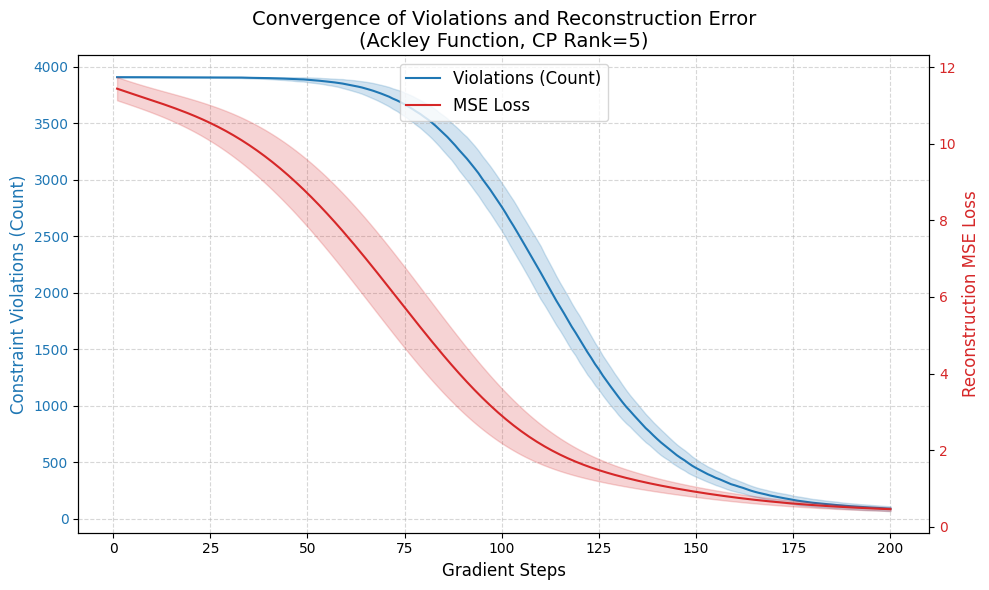

In [2]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# ==============================================================================
# 1. クラス定義 (AckleyTF & TensorFactorization)
# ==============================================================================

class AckleyTF:
    def __init__(self):
        self.bounds = [-32, 32]
        self.radius = 10
        self.n_dim = 2
        self.fmax = 22.3497
        self._tensor_constraint = None
        self._build_constraint()

    def _build_constraint(self) -> None:
        X, Y = np.meshgrid(
            np.arange(self.bounds[0], self.bounds[1] + 1),
            np.arange(self.bounds[0], self.bounds[1] + 1)
        )
        R_squared = X**2 + Y**2
        self._tensor_constraint = (R_squared <= self.radius**2).astype(int)

    def function(self, x, y):
        a, b, c = 20, 0.2, 2*np.pi
        d = 2
        sum1 = -a * np.exp(-b * np.sqrt((x**2 + y**2) / d))
        sum2 = -np.exp((np.cos(c * x) + np.cos(c * y)) / d)
        return sum1 + sum2 + a + np.exp(1)

    def get_data(self):
        x = np.arange(self.bounds[0], self.bounds[1] + 1)
        y = np.arange(self.bounds[0], self.bounds[1] + 1)
        X, Y = np.meshgrid(x, y)
        Z = self.function(X, Y)
        tensor_data = torch.tensor(Z, dtype=torch.float32)
        constraint_mask = torch.tensor(self._tensor_constraint, dtype=torch.float32)
        return tensor_data, constraint_mask


class TensorFactorization:
    def __init__(
        self, tensor, rank, method="cp", mask=None, constraint=None,  
        is_maximize_c=True, device=None, verbose=False
    ):
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device

        tensor = tensor.to(self.device)
        if mask is None: mask = torch.ones_like(tensor, device=self.device)
        else: mask = mask.to(self.device)
        if constraint is None: constraint = torch.ones_like(tensor, device=self.device)
        else: constraint = constraint.to(self.device)

        self.tensor = tensor
        self.mask = mask
        self.constraint = constraint
        self.is_maximize_c = is_maximize_c
        self.method = method.lower()
        self.rank = rank
        self.dims = tensor.shape
        
        # CP分解の初期化
        self.factors = [torch.randn(dim, rank, requires_grad=True, device=self.device) 
                        for dim in self.dims]
        
        # ログ用
        self.loss_history = {
            "epoch": [], "total": [], "mse": [], "constraint": [], "violation_count": []
        }

    def reconstruct(self):
        # CP分解の再構成
        R = self.rank
        recon = torch.zeros_like(self.tensor, device=self.device)
        for r in range(R):
            component = self.factors[0][:, r]
            for mode in range(1, len(self.dims)):
                component = torch.ger(component, self.factors[mode][:, r]).flatten()
            recon += component.view(*self.dims)
        return recon

    def optimize(
        self, lr=0.01, max_iter=200, reg_lambda=0.0, constraint_lambda=1, thr=0.5
    ):
        params = self.factors
        optimizer = optim.Adam(params, lr=lr)
        
        if self.is_maximize_c: sign = 1
        else: sign = -1
        
        iteration = 0
        while iteration < max_iter:
            optimizer.zero_grad()
            reconstruction = self.reconstruct()

            # --- 損失計算 ---
            n_se = torch.sum(self.mask)
            n_c = torch.sum(1 - self.constraint)
            n_c = n_c if n_c > 0 else 1
            
            # 1. MSE Loss (観測データとの誤差)
            error_term = self.constraint * self.mask * (self.tensor - reconstruction)
            mse_loss = torch.norm(error_term) ** 2 / n_se if n_se > 0 else 0

            # 2. 制約項 (制約違反へのペナルティ)
            raw_violation = (1 - self.constraint) * sign * (reconstruction - thr)
            violation_term = torch.clamp(raw_violation, min=0)
            constraint_loss = constraint_lambda * torch.sum(violation_term) / n_c

            # 3. 正則化項
            l2_loss = torch.tensor(0., device=self.device)
            for p in params: l2_loss += torch.norm(p) ** 2 / p.numel()
            l2_loss *= reg_lambda

            total_loss = mse_loss + constraint_loss + l2_loss
            total_loss.backward()
            optimizer.step()

            # --- 履歴の記録 ---
            with torch.no_grad():
                # 違反カウント (離散値)
                count = torch.sum(violation_term > 0).item()
                self.loss_history["violation_count"].append(count)
                
                # MSE (浮動小数点)
                self.loss_history["mse"].append(mse_loss.item())

            self.loss_history["epoch"].append(iteration+1)
            iteration += 1

        return params

# ==============================================================================
# 2. 実験実行と2軸プロット
# ==============================================================================

def run_experiment_and_plot_dual_axis():
    # --- 設定 ---
    N_SEEDS = 10
    MAX_ITER = 200
    RANK = 5
    LR = 0.01
    CONSTRAINT_LAMBDA = 10.0
    IS_MAXIMIZE_C = False 
    THRESHOLD = 10.0 
    
    # データの準備
    ackley = AckleyTF()
    tensor_data, constraint_mask = ackley.get_data()
    
    # 履歴格納用
    all_violations = []
    all_mses = []
    
    print(f"Running experiment with {N_SEEDS} seeds...")
    
    for seed in range(N_SEEDS):
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        tf = TensorFactorization(
            tensor=tensor_data,
            rank=RANK,
            method="cp",
            mask=torch.ones_like(tensor_data),
            constraint=constraint_mask,
            is_maximize_c=IS_MAXIMIZE_C,
            device=torch.device("cpu")
        )
        
        tf.optimize(
            lr=LR,
            max_iter=MAX_ITER,
            reg_lambda=0.001,
            constraint_lambda=CONSTRAINT_LAMBDA,
            thr=THRESHOLD
        )
        
        all_violations.append(tf.loss_history["violation_count"])
        all_mses.append(tf.loss_history["mse"])
        print(f"  Seed {seed+1} completed.")

    # --- 集計 ---
    violations_arr = np.array(all_violations) # (10, 200)
    mses_arr = np.array(all_mses)             # (10, 200)
    
    mean_vio = np.mean(violations_arr, axis=0)
    std_vio = np.std(violations_arr, axis=0)
    
    mean_mse = np.mean(mses_arr, axis=0)
    std_mse = np.std(mses_arr, axis=0)
    
    steps = np.arange(1, MAX_ITER + 1)
    
    # --- プロット作成 (2軸) ---
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 左軸: Constraint Violations (青系)
    color_vio = 'tab:blue'
    ax1.set_xlabel('Gradient Steps', fontsize=12)
    ax1.set_ylabel('Constraint Violations (Count)', color=color_vio, fontsize=12)
    line1 = ax1.plot(steps, mean_vio, color=color_vio, label='Violations (Count)')
    ax1.fill_between(steps, mean_vio - std_vio, mean_vio + std_vio, color=color_vio, alpha=0.2)
    ax1.tick_params(axis='y', labelcolor=color_vio)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # 右軸: MSE Loss (赤系)
    ax2 = ax1.twinx()  # 2つ目の軸を作成
    color_mse = 'tab:red'
    ax2.set_ylabel('Reconstruction MSE Loss', color=color_mse, fontsize=12)
    line2 = ax2.plot(steps, mean_mse, color=color_mse, label='MSE Loss')
    ax2.fill_between(steps, mean_mse - std_mse, mean_mse + std_mse, color=color_mse, alpha=0.2)
    ax2.tick_params(axis='y', labelcolor=color_mse)

    # 凡例をまとめて表示
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper center', fontsize=12)

    plt.title("Convergence of Violations and Reconstruction Error\n(Ackley Function, CP Rank=5)", fontsize=14)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_experiment_and_plot_dual_axis()